In [5]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

In [6]:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')
print(out)
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

/home/bakingsoda/side/tabnet/data/census-income.csv
File already exists.


In [7]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [8]:
train

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Set
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,train
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,valid
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,train
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,train


In [9]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    """
    fill na and label encoding
    """
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


In [10]:

unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
print(cat_dims)

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

[9, 16, 7, 15, 6, 5, 2, 42]


In [11]:

clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cpu


In [12]:

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [13]:

max_epochs = 10 if not os.getenv("CI", False) else 2

In [14]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.17403 | train_rmsle: 0.09588 | train_mae: 0.36409 | train_rmse: 0.4223  | train_mse: 0.17834 | valid_rmsle: 0.09463 | valid_mae: 0.35997 | valid_rmse: 0.4182  | valid_mse: 0.17489 |  0:00:03s
epoch 1  | loss: 0.13584 | train_rmsle: 0.0807  | train_mae: 0.30876 | train_rmse: 0.39314 | train_mse: 0.15456 | valid_rmsle: 0.07864 | valid_mae: 0.30546 | valid_rmse: 0.38645 | valid_mse: 0.14934 |  0:00:07s
epoch 2  | loss: 0.12665 | train_rmsle: 0.08361 | train_mae: 0.31853 | train_rmse: 0.39482 | train_mse: 0.15588 | valid_rmsle: 0.07885 | valid_mae: 0.30884 | valid_rmse: 0.38205 | valid_mse: 0.14596 |  0:00:11s
epoch 3  | loss: 0.1226  | train_rmsle: 0.09737 | train_mae: 0.31931 | train_rmse: 0.42312 | train_mse: 0.17903 | valid_rmsle: 0.09386 | valid_mae: 0.31177 | valid_rmse: 0.41256 | valid_mse: 0.17021 |  0:00:14s
epoch 4  | loss: 0.11839 | train_rmsle: 0.07256 | train_mae: 0.27925 | train_rmse: 0.36734 | train_mse: 0.13494 | valid_rmsle: 0.07058 | valid_mae: 0.27474 

In [ ]:
clf.feature_importances_

In [16]:
features

['39',
 ' State-gov',
 ' 77516',
 ' Bachelors',
 ' 13',
 ' Never-married',
 ' Adm-clerical',
 ' Not-in-family',
 ' White',
 ' Male',
 ' 2174',
 ' 0',
 ' 40',
 ' United-States']

In [17]:
imp = pd.DataFrame([features, clf.feature_importances_],index=["name","imp"]).T.sort_values(by=["imp"],ascending=False)
imp

,name,imp
6,Adm-clerical,0.261146
5,Never-married,0.18978
3,Bachelors,0.18704
0,39,0.103333
13,United-States,0.067392
9,Male,0.042112
10,2174,0.039011
7,Not-in-family,0.037336
4,13,0.036053
8,White,0.016586


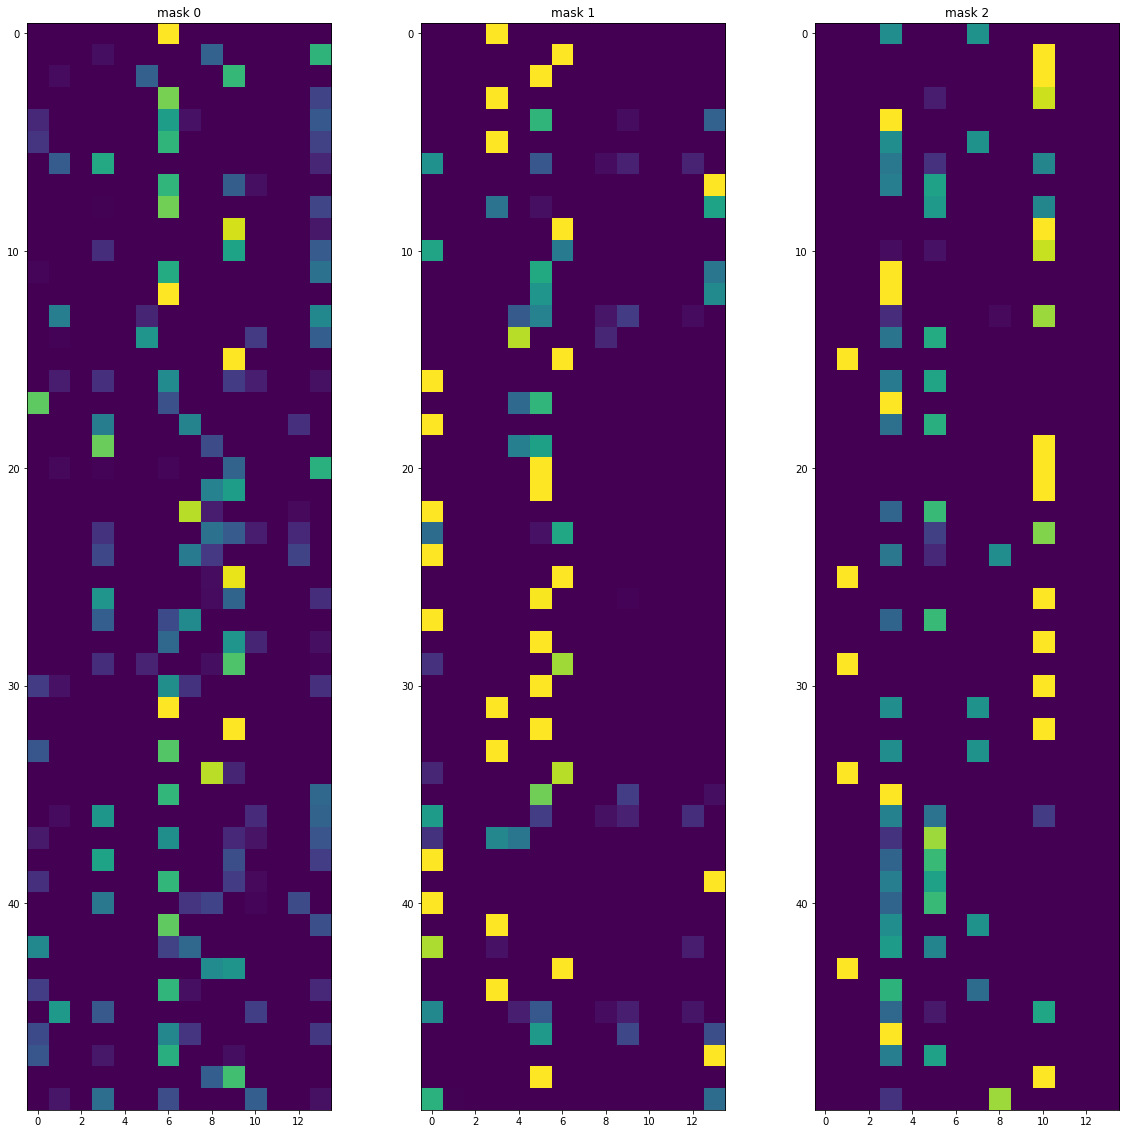

In [19]:
import matplotlib.pyplot as plt
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")